In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import numpy as np
import pandas as pd
import io
import sys
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.models import Sequential
from tensorflow.keras.callbacks import *
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D,Masking, Dropout, Activation
from keras.layers.advanced_activations import PReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras import initializers
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 32
EMBEDDING_DIM = 300

train_df = pd.read_csv("/gdrive/My Drive/Project-DataSceince/train_normalized.csv", sep='\t', encoding='utf-16')

dev_df = pd.read_csv("/gdrive/My Drive/Project-DataSceince/valid_normalized.csv", sep='\t', encoding='utf-16')

test_df = pd.read_csv('/gdrive/My Drive/Project-DataSceince/test_normalized.csv', sep='\t', encoding='utf-16')

In [ ]:
train_df

,tweet_content,label
0,بالاضافة لقيام معلمو الجيزة للذهاب الي جريدة ا...,MSA
1,بعدين والله حرام تجي تلقى الي واقف الاشاره با...,MSA
2,لمسه اليد مرتين واضحة جدا والحكم,DIAL_LEV
3,بخصوص الهاتريك عمرها تصير,DIAL_LEV
4,الله يجبر كسرهم ويرجع لدهم اليوم بكرى,DIAL_GLF
...,...,...
79585,وبورسعيد حكايتها,DIAL_LEV
79586,الان لبس الزي الرسمي السعودي يكون نظره عليا...,MSA
79587,اتوقع والله اعلم انه يقصد بقية الشعب المسافرين...,DIAL_GLF
79588,بيتبدأ,DIAL_EGY


In [ ]:
texts_train, labels_train = train_df['tweet_content'], train_df['label']
texts_dev, labels_dev = dev_df['tweet_content'], dev_df['label']
texts_test, labels_test = test_df['tweet_content'], test_df['label']

print(texts_train.shape)

train_df.head()

(79590,)


,tweet_content,label
0,بالاضافة لقيام معلمو الجيزة للذهاب الي جريدة ا...,MSA
1,بعدين والله حرام تجي تلقى الي واقف الاشاره با...,MSA
2,لمسه اليد مرتين واضحة جدا والحكم,DIAL_LEV
3,بخصوص الهاتريك عمرها تصير,DIAL_LEV
4,الله يجبر كسرهم ويرجع لدهم اليوم بكرى,DIAL_GLF


In [ ]:
labels_train = labels_train.astype('category')
labels_train = labels_train.cat.codes

labels_dev = labels_dev.astype('category')
labels_dev = labels_dev.cat.codes

labels_test = labels_test.astype('category') 
labels_test = labels_test.cat.codes 

In [ ]:
labels_train

0        3
1        3
2        2
3        2
4        1
        ..
79585    2
79586    3
79587    1
79588    0
79589    2
Length: 79590, dtype: int8

In [ ]:
x_train = texts_train
y_train = labels_train

x_dev = texts_dev
y_dev = labels_dev

x_test = texts_test
y_test = labels_test

x_train.shape, y_train.shape, x_dev.shape, y_dev.shape, x_test.shape, y_test.shape

((79590,), (79590,), (9727,), (9727,), (10209,), (10209,))

In [ ]:
y_train = np.asarray(pd.get_dummies(train_df.label), dtype = np.int8)
y_dev = np.asarray(pd.get_dummies(dev_df.label), dtype = np.int8)
y_test = np.asarray(pd.get_dummies(test_df.label), dtype = np.int8)

In [ ]:
tokquestions = x_train.astype(str)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(tokquestions)
tokquestion1_word_sequences = tokenizer.texts_to_sequences(x_train.astype(str))
word_index = tokenizer.word_index

print("Words in index: %d" % len(word_index))

Words in index: 161409


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz

--2022-09-02 13:58:58--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G  25.2MB/s    in 62s     

2022-09-02 14:00:00 (19.6 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [ ]:
!gunzip /content/cc.ar.300.vec.gz

In [ ]:
embeddings_index = {}
with open("cc.ar.300.vec", encoding='utf8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))

nb_words = min(MAX_NB_WORDS, len(word_index))
word_embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
        

print('Null word embeddings: %d' % np.sum(np.sum(word_embedding_matrix, axis=1) == 0))

Word embeddings: 2000000
Null word embeddings: 654


In [ ]:
# def get_sequances(texts, sequence_length):
#     excerpt = pad_sequences(tokenizer.texts_to_sequences(texts[:, 0]), sequence_length)
#     return excerpt

In [ ]:
train_tweet = pad_sequences(tokenizer.texts_to_sequences(x_train.astype(str)), MAX_SEQUENCE_LENGTH)
dev_tweet = pad_sequences(tokenizer.texts_to_sequences(x_dev.astype(str)), MAX_SEQUENCE_LENGTH)
test_tweet = pad_sequences(tokenizer.texts_to_sequences(x_test.astype(str)), MAX_SEQUENCE_LENGTH)

In [ ]:
filter_length = 5
nb_filter = 128
pool_length = 4

In [ ]:
'''t11 = Embedding(nb_words + 1,
                    embedding_dim,
                    weights=[embeddings_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False)(input_tweet)

    t11 = TimeDistributed(Dense(256, activation='relu'))(t11)
    t11 = Lambda(lambda x: K.sum(x, axis=1), output_shape=(256,))(t11)'''

"t11 = Embedding(nb_words + 1,\n                    embedding_dim,\n                    weights=[embeddings_matrix],\n                    input_length=MAX_SEQUENCE_LENGTH,\n                    trainable=False)(input_tweet)\n\n    t11 = TimeDistributed(Dense(256, activation='relu'))(t11)\n    t11 = Lambda(lambda x: K.sum(x, axis=1), output_shape=(256,))(t11)"

In [ ]:
def buildModel(embeddings_matrix, sequence_length, lstm_dim, hidden_layer_dim, num_classes,
               noise=0.1, dropout_lstm=0.2, dropout=0.2):
    input_tweet = Input(shape=(sequence_length,), dtype='int32')
    embedding_dim = embeddings_matrix.shape[1]
    
    x = Embedding(nb_words + 1,
                    embedding_dim,
                    weights=[embeddings_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False)(input_tweet)
    x = Masking(mask_value=0.0)(x)

#model.add(LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.2))
    #x = Bidirectional(GRU(128, kernel_initializer=initializers.RandomNormal(stddev=0.01), dropout=0.5, recurrent_dropout=0.2 ))(x)
    #kernel_initializer='normal'
    x = Bidirectional(GRU(128, dropout=0.5, recurrent_dropout=0.2 ))(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    #x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    # x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    # x = Dropout(0.2)(x)kernel_initializer=RandomNormal(stddev=self.std)
    # x = BatchNormalization()(x)

    # x = Dense(hidden_layer_dim, activation='relu', kernel_regularizer=l2(0.001))(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tweet, outputs=output)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

    return model

In [ ]:
model = buildModel(word_embedding_matrix,
                   MAX_SEQUENCE_LENGTH, 
                   lstm_dim=128, 
                   hidden_layer_dim=30, 
                   num_classes=4)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 embedding (Embedding)       (None, 32, 300)           15000300  
                                                                 
 masking (Masking)           (None, 32, 300)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              330240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                             

In [ ]:
filepath = "modelgru.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, mode='auto', epsilon=0.0001)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=7)



In [ ]:
callbacks_list = [checkpoint, reduceLROnPlat, early]

history = model.fit(train_tweet, np.array(y_train),
                    callbacks=callbacks_list,
                    validation_data=(dev_tweet, np.array(y_dev)),
                    epochs=50,
                    batch_size=128)



Epoch 1/50
622/622 [==============================] - ETA: 0s - loss: 1.2776 - categorical_accuracy: 0.7402
Epoch 1: val_loss improved from inf to 0.93984, saving model to modelgru.h5
622/622 [==============================] - 343s 537ms/step - loss: 1.2776 - categorical_accuracy: 0.7402 - val_loss: 0.9398 - val_categorical_accuracy: 0.8035 - lr: 0.0010
Epoch 2/50
622/622 [==============================] - ETA: 0s - loss: 0.8547 - categorical_accuracy: 0.7838
Epoch 2: val_loss improved from 0.93984 to 0.68177, saving model to modelgru.h5
622/622 [==============================] - 343s 552ms/step - loss: 0.8547 - categorical_accuracy: 0.7838 - val_loss: 0.6818 - val_categorical_accuracy: 0.8087 - lr: 0.0010
Epoch 3/50
622/622 [==============================] - ETA: 0s - loss: 0.6814 - categorical_accuracy: 0.7882
Epoch 3: val_loss improved from 0.68177 to 0.57462, saving model to modelgru.h5
622/622 [==============================] - 336s 541ms/step - loss: 0.6814 - categorical_accuracy

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/gd\rive/My Drive/Project-DataSceince/modelGRU50.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/gdrive/My Drive/Project-DataSceince/modelGRU50.h5")
print("Saved model to disk")

Saved model to disk


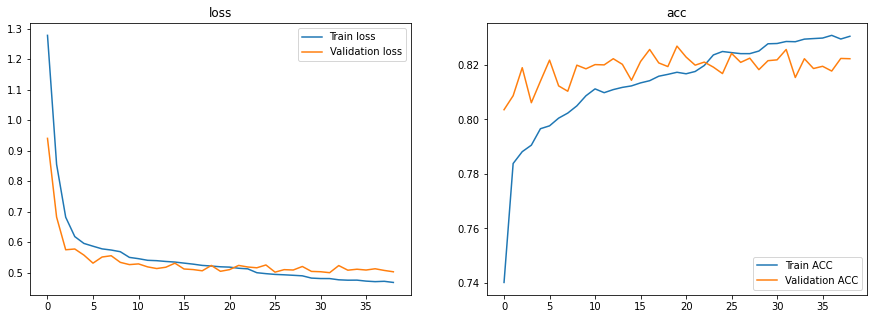

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(history.epoch, history.history["categorical_accuracy"], label="Train ACC")
ax[1].plot(history.epoch, history.history["val_categorical_accuracy"], label="Validation ACC")
ax[0].legend()
ax[1].legend()

In [ ]:
y_pred = model.predict(train_tweet)

print(classification_report(y_train.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      9429
           1       0.79      0.71      0.75     16121
           2       0.90      0.69      0.78      8810
           3       0.85      0.94      0.90     45230

    accuracy                           0.85     79590
   macro avg       0.86      0.78      0.81     79590
weighted avg       0.85      0.85      0.84     79590



In [ ]:
y_pred = model.predict(dev_tweet)

print(classification_report(y_dev.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.71      0.75       674
           1       0.83      0.66      0.73      2036
           2       0.69      0.61      0.65      1079
           3       0.84      0.93      0.88      5938

    accuracy                           0.82      9727
   macro avg       0.79      0.73      0.75      9727
weighted avg       0.82      0.82      0.82      9727



In [ ]:
y_pred = model.predict(test_tweet)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1220
           1       0.84      0.64      0.73      2035
           2       0.65      0.63      0.64      1049
           3       0.83      0.94      0.88      5905

    accuracy                           0.83     10209
   macro avg       0.81      0.74      0.77     10209
weighted avg       0.83      0.83      0.82     10209



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


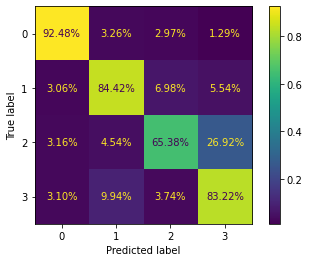

In [ ]:
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
plot_confusion_matrix(IC, y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='true', values_format='.2%');

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
#precision = precision_score(ytest, y_pred)
precision = precision_score (y_test.argmax(axis=1), y_pred.argmax(axis=1), average='micro')
recall = recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
#recall = recall_score(ytest, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='micro')
print('F1 score: %f' % f1)

Accuracy: 0.825448
Precision: 0.825448
Recall: 0.825448
F1 score: 0.825448


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
#precision = precision_score(ytest, y_pred)
precision = precision_score (y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')
recall = recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
#recall = recall_score(ytest, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.825448
Precision: 0.813763
Recall: 0.742990
F1 score: 0.772049


In [ ]:
from google.colab import files
import os

dir_to_zip = 'tf_model' #@param {type: "string"}
output_filename = 'tf_model.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )